# Mitigating Overfitting: An In-Depth Look at Dropout Implementation and Impact

This notebook delves into the practical problem of **overfitting** in neural networks and showcases **how dropout regularization effectively combats it**. We'll begin by observing a model prone to overfitting, then implement a **custom dropout layer from scratch** in Keras, and finally analyze how dropout's mechanisms lead to improved generalization and prevent the model from memorizing noisy data.

In [110]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.datasets import make_blobs
from sklearn.preprocessing import StandardScaler

In [111]:
# Generating synthetic data
X, y = make_blobs(n_samples=200, centers=2, n_features=2, cluster_std=0.8, random_state=42)

np.random.seed(42)

idx_class_0 = np.where(y == 0)[0]
idx_class_1 = np.where(y == 1)[0]

noisy_indices_0_to_1 = np.random.choice(idx_class_0, 5, replace=False)
y[noisy_indices_0_to_1] = 1

noisy_indices_1_to_0 = np.random.choice(idx_class_1, 20, replace=False)
y[noisy_indices_1_to_0] = 0

In [112]:
# Scaling featurs
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

Training data shape: (140, 2), (140,)
Validation data shape: (60, 2), (60,)


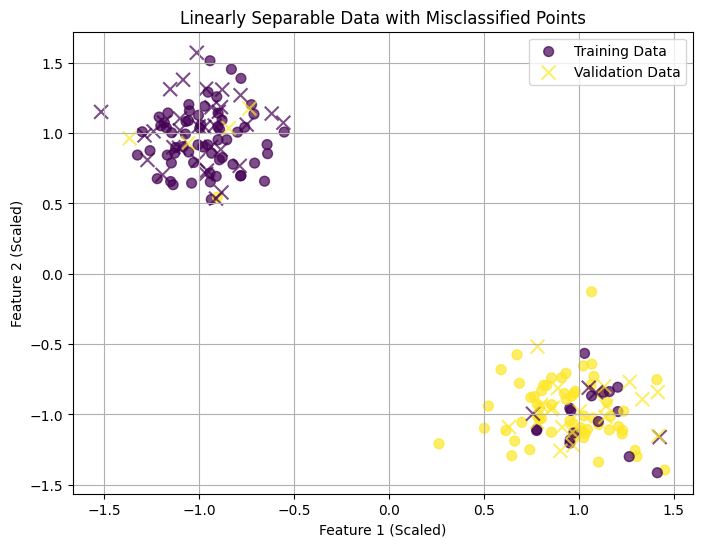

In [113]:
# Split into training and validation
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X_scaled, y, test_size = 0.3, random_state = 42)

print(f"Training data shape: {X_train.shape}, {y_train.shape}")
print(f"Validation data shape: {X_val.shape}, {y_val.shape}")

plt.figure(figsize=(8, 6))
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap='viridis', s=50, alpha=0.7, label='Training Data')
plt.scatter(X_val[:, 0], X_val[:, 1], c=y_val, cmap='viridis', marker='x', s=100, alpha=0.7, label='Validation Data')
plt.title('Linearly Separable Data with Misclassified Points')
plt.xlabel('Feature 1 (Scaled)')
plt.ylabel('Feature 2 (Scaled)')
plt.legend()
plt.grid(True)
plt.show()

In [114]:
# Neural network without dropout
def build_simple_model():
  model = keras.Sequential([
      layers.Dense(64, activation = 'relu', input_shape = (2,)),
      layers.Dense(64, activation = 'relu'),
      layers.Dense(64, activation = 'relu'),
      layers.Dense(32, activation = 'relu'),
      layers.Dense(1, activation = 'sigmoid')
  ])
  model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
  return model

model_without_dropout = build_simple_model()
model_without_dropout.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_57 (Dense)                │ (None, 64)             │           192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_58 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_59 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_60 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_61 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,625 (41.50 KB)

 Trainable params: 10,625 (41.50 KB)

 Non-trainable params: 0 (0.00 B)

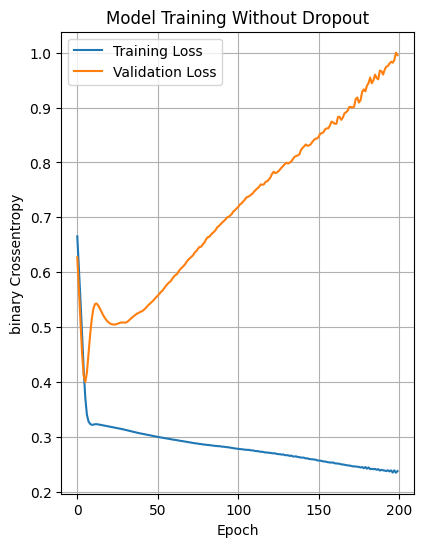

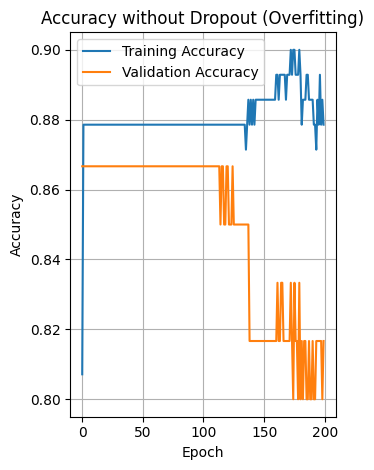

In [115]:
# Training the model
history_without_dropout = model_without_dropout.fit(X_train, y_train,
                                                    epochs = 200,
                                                    batch_size = 32,
                                                    validation_data = (X_val, y_val),
                                                    verbose = 0)
# plotting loss and accuracy
plt.figure(figsize = (10, 6))

plt.subplot(1, 2, 2)
plt.plot(history_without_dropout.history['loss'], label = 'Training Loss')
plt.plot(history_without_dropout.history['val_loss'], label = 'Validation Loss')
plt.title('Model Training Without Dropout')
plt.xlabel('Epoch')
plt.ylabel('binary Crossentropy')
plt.legend()
plt.grid(True)
plt.show()

plt.subplot(1, 2, 2)
plt.plot(history_without_dropout.history['accuracy'], label='Training Accuracy')
plt.plot(history_without_dropout.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy without Dropout (Overfitting)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


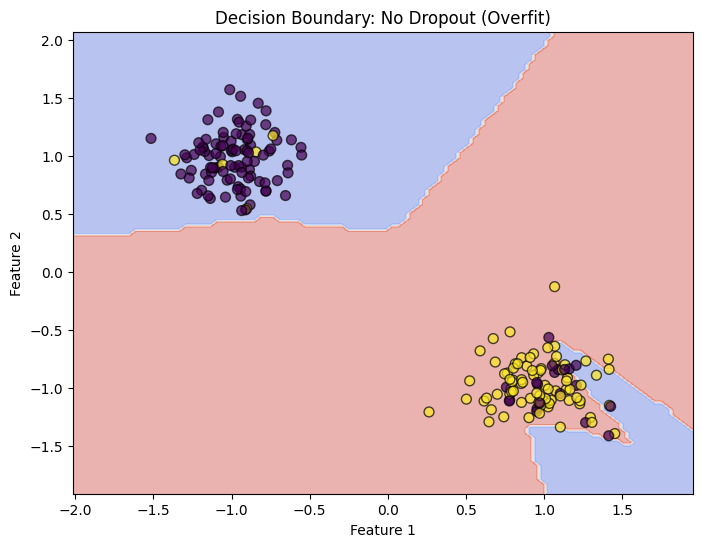

In [116]:
# decision boundary
def plot_decision_boundary(model, X, y, title, ax):
    x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
    y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100),
                         np.linspace(y_min, y_max, 100))
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    Z = (Z > 0.5).astype(int)

    ax.contourf(xx, yy, Z, alpha=0.4, cmap='coolwarm')
    ax.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='viridis', edgecolors='k', alpha=0.7)
    ax.set_title(title)
    ax.set_xlabel('Feature 1')
    ax.set_ylabel('Feature 2')


fig, ax = plt.subplots(figsize=(8, 6))
plot_decision_boundary(model_without_dropout, X_scaled, y, 'Decision Boundary: No Dropout (Overfit)', ax)
plt.show()

## Overfitting Due to Model Complexity

When training machine learning models, our goal is for them to learn the underlying patterns in the data and generalize well to unseen examples. However, a model with a highly complex architecture – meaning it has many layers, a large number of neurons per layer, or intricate connections – can easily fall into the trap of **overfitting**.

Overfitting occurs when the model learns the training data *too well*, including its noise, outliers, and specific quirks. Instead of capturing the general trends, it essentially memorizes the training set. This leads to excellent performance on the data it has seen before but significantly worse performance on new, unseen data (like our validation set).

**Here's why a complex architecture contributes to overfitting:**

* **High Capacity:** A complex model has a high learning capacity. It possesses enough "degrees of freedom" (the trainable parameters) to model even very intricate and potentially spurious relationships within the training data. Think of it like trying to fit a very wiggly curve through a set of points – it can pass through almost every single point, even if those points don't truly represent the underlying trend.
* **Memorization of Noise:** Noise in the training data is random fluctuation that doesn't generalize. A complex model can inadvertently learn these noisy patterns as if they were meaningful signals.
* **Lack of Generalization:** By focusing too much on the training data's specifics, the model fails to learn the broader, more robust features that would allow it to make accurate predictions on new data drawn from the same underlying distribution.

**In the context of our neural network without dropout:**

We built a model with multiple dense layers and a significant number of neurons. This architecture, while capable of learning complex relationships, was also prone to memorizing the specific patterns (and noise) in our training data. As a result, while the training loss decreased significantly and the training accuracy increased, the validation loss plateaued or even increased, and the validation accuracy lagged behind. This divergence between training and validation performance is a clear indicator of overfitting. The model essentially became too specialized to the training set and lost its ability to generalize.

In [117]:
# Dropout
class CustomDropout(layers.Layer):
  def __init__(self, rate, **kwargs):
    super(CustomDropout, self).__init__(**kwargs)
    if not 0 <= rate <= 1:
      raise ValueError(f"Dropout rate must be between 0 annd 1. Got: {rate}")
    self.rate = rate

  def call(self, inputs, training = None):
    if training:
      keep_prob = 1.0 - self.rate
      mask = tf.cast(tf.random.uniform(tf.shape(inputs)) > self.rate, dtype = tf.float32)
      outputs = inputs * mask / keep_prob
    else:
      outputs = inputs
    return outputs

  def get_config(self):
    config = super(CustomerDropout, self).get.config()
    config.update({"rate": self.rate})
    return config



## Implementing Dropout from Scratch (Custom Keras Layer)

To combat overfitting, we implemented the dropout regularization technique from scratch as a custom layer within the Keras framework. Dropout works by randomly "dropping out" (i.e., setting to zero) a fraction of the neurons in a layer during each training update. This prevents neurons from co-adapting too much and forces the network to learn more robust and independent features.

Here's how our `CustomDropout` layer was implemented:

1.  **Creating a Custom Layer:** We subclassed the `tf.keras.layers.Layer` class. This is the standard way to define custom layers with specific behavior in Keras.

2.  **Initialization (`__init__` method):**
    * Our layer's constructor takes a `rate` parameter. This `rate` (a float between 0 and 1) determines the probability of each neuron being dropped out during training.
    * We store this `rate` as an instance attribute.
    * We also call the `super().__init__(**kwargs)` to handle any necessary initialization from the parent `Layer` class.

3.  **The `call` Method (Defining the Layer's Logic):**
    * The `call` method defines the forward pass of our custom layer. It takes the `inputs` from the previous layer and a `training` boolean argument. This `training` flag is crucial because dropout should only be applied during the training phase, not during evaluation or inference.
    * **Dropout Application (if `training` is True):**
        * We calculate the `keep_prob` as `1.0 - self.rate`. This is the probability of a neuron *not* being dropped out.
        * We generate a random binary mask with the same shape as the `inputs`. Each element in the mask is `True` with probability `keep_prob` and `False` with probability `self.rate`.
        * We cast this boolean mask to a float tensor (0.0 for `False`, 1.0 for `True`).
        * We apply the mask to the `inputs` by element-wise multiplication. This effectively sets the outputs of the "dropped out" neurons to zero.
        * **Inverted Dropout (Scaling):** We divide the masked outputs by `keep_prob`. This scaling step is important to maintain the expected magnitude of the outputs during training. During inference (when dropout is off), all neurons are active, so we need to compensate for the fact that fewer neurons were active during training.
    * **No Dropout (if `training` is False):** If the `training` flag is `False`, we simply pass the `inputs` through without applying any dropout.

4.  **`get_config` Method:**
    * This method is important for serialization and saving/loading models that use our custom layer. It returns a dictionary containing the configuration parameters of the layer (in our case, just the `rate`).

By implementing dropout in this way, we created a reusable layer that can be easily inserted into our Keras sequential model to introduce regularization during training.

In [118]:
# Neural network with dropout
def new_model(dropout_rate = 0.3):
  model = keras.Sequential([
      layers.Dense(64, activation = 'relu', input_shape = (2,)),
      CustomDropout(dropout_rate),
      layers.Dense(64, activation = 'relu'),
      CustomDropout(dropout_rate),
      layers.Dense(64, activation = 'relu'),
      CustomDropout(dropout_rate),
      layers.Dense(32, activation = 'relu'),
      CustomDropout(dropout_rate),
      layers.Dense(1, activation = 'sigmoid')
  ])
  model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
  return model

model_with_dropout = new_model(dropout_rate = 0.3)
model_with_dropout.summary()

Model: "sequential_16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_62 (Dense)                │ (None, 64)             │           192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ custom_dropout_14               │ (None, 64)             │             0 │
│ (CustomDropout)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_63 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ custom_dropout_15               │ (None, 64)             │             0 │
│ (CustomDropout)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_64 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ custom_dropout_16               │ (None, 64)             │             0 │
│ (CustomDropout)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_65 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ custom_dropout_17               │ (None, 32)             │             0 │
│ (CustomDropout)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_66 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,625 (41.50 KB)

 Trainable params: 10,625 (41.50 KB)

 Non-trainable params: 0 (0.00 B)

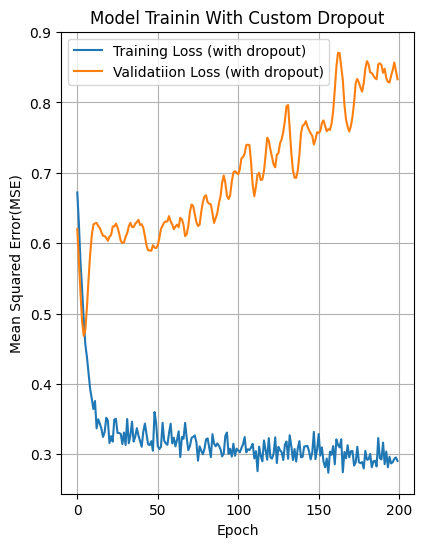

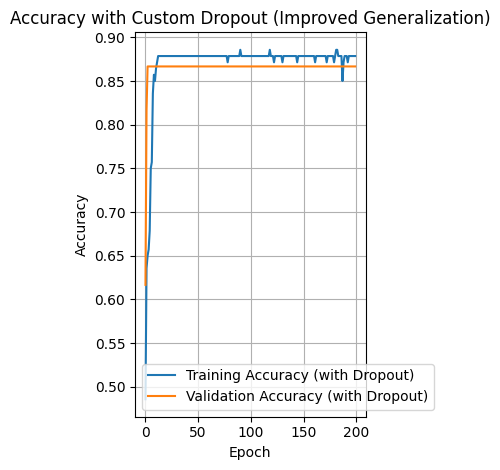

In [119]:
# Training the new Model
history_with_dropout = model_with_dropout.fit(X_train, y_train,
                                     epochs = 200,
                                     batch_size = 32,
                                     validation_data = (X_val, y_val),
                                     verbose = 0)

# plotting loss and accuracy
plt.figure(figsize = (10,6))

plt.subplot(1, 2, 1)
plt.plot(history_with_dropout.history['loss'], label = 'Training Loss (with dropout)')
plt.plot(history_with_dropout.history['val_loss'], label = 'Validatiion Loss (with dropout)')
plt.title('Model Trainin With Custom Dropout')
plt.xlabel('Epoch')
plt.ylabel('Mean Squared Error(MSE)')
plt.legend()
plt.grid(True)
plt.show()

plt.subplot(1, 2, 2)
plt.plot(history_with_dropout.history['accuracy'], label='Training Accuracy (with Dropout)')
plt.plot(history_with_dropout.history['val_accuracy'], label='Validation Accuracy (with Dropout)')
plt.title('Accuracy with Custom Dropout (Improved Generalization)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


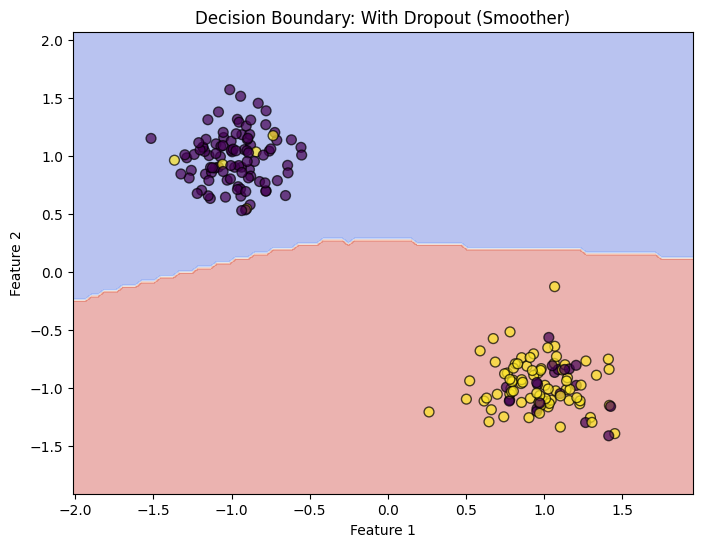

In [120]:
# decision boundary
def plot_decision_boundary(model, X, y, title, ax):
    x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
    y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100),
                         np.linspace(y_min, y_max, 100))

    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    Z = (Z > 0.5).astype(int)

    ax.contourf(xx, yy, Z, alpha=0.4, cmap='coolwarm')
    ax.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='viridis', edgecolors='k', alpha=0.7)
    ax.set_title(title)
    ax.set_xlabel('Feature 1')
    ax.set_ylabel('Feature 2')
fig, ax = plt.subplots(figsize=(8, 6))
plot_decision_boundary(model_with_dropout, X_scaled, y, 'Decision Boundary: With Dropout (Smoother)', ax)
plt.show()

## How Dropout Prevents Overfitting by "Ignoring" Neurons

Dropout is a powerful regularization technique that helps prevent neural networks from overfitting by randomly deactivating a fraction of neurons during each training iteration. This seemingly simple process has several key effects that contribute to improved generalization:

* **Reduces Co-adaptation of Neurons:** When a complex network trains without regularization, neurons can start to heavily rely on the presence and specific activation of other neurons in the same layer. They can become "co-adapted," meaning they learn features that are only useful in the context of those specific partner neurons. Dropout disrupts these co-dependencies. By randomly dropping out neurons, it forces the remaining active neurons to learn more robust and independent features that are useful even without their usual collaborators.

* **Acts Like Training Multiple Networks:** Each time dropout is applied with a different random mask of dropped neurons, it's as if we are training a slightly different sub-network. At inference time, when no dropout is applied, the network can be seen as an ensemble (an average) of all these different sub-networks trained during training. Ensemble methods are known to often generalize better than single models.

* **Prevents Over-Reliance on Specific Inputs:** Dropout makes the network less sensitive to the specific values of individual neurons in the previous layer. Since any given neuron might be dropped out, the downstream neurons cannot rely too heavily on a single input to make their predictions. This encourages the network to learn more distributed and robust representations of the input data.

* **Reduces the Effective Complexity of the Network:** By randomly deactivating neurons, dropout effectively reduces the complexity of the network being trained in each iteration. This prevents the model from having the full capacity to memorize the training data's noise and specific details.

**In our example with dropout:**

By adding `CustomDropout` layers to our neural network, we forced the model to train with different subsets of its neurons active in each forward and backward pass. This prevented specific neurons from becoming overly specialized to particular training examples or noise patterns. The network learned more generalizable features, leading to:

* A smaller gap between the training and validation loss/accuracy.
* A more stable validation performance over epochs.
* A smoother and more intuitive decision boundary that wasn't overly influenced by the noisy "misclassified" points in our synthetic dataset.

In essence, dropout acts as a form of stochastic regularization, injecting noise into the training process in a way that encourages the network to learn more resilient and generalizable representations, ultimately mitigating the problem of overfitting.

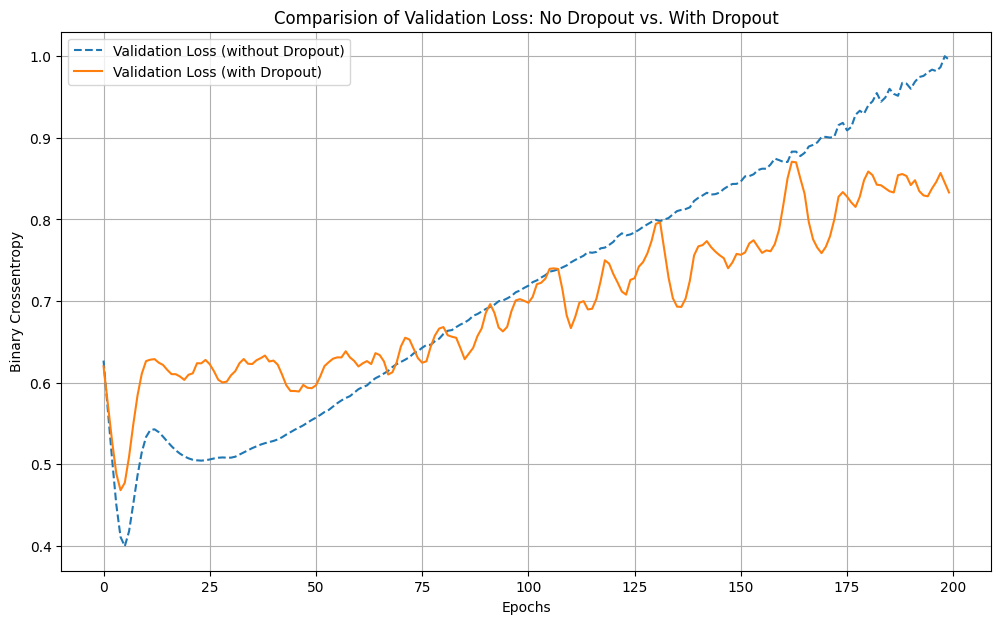

In [121]:
# Comparision
plt.figure(figsize = (12,7))
plt.plot(history_without_dropout.history['val_loss'], label = 'Validation Loss (without Dropout)', linestyle = '--')
plt.plot(history_with_dropout.history['val_loss'], label = 'Validation Loss (with Dropout)')
plt.title('Comparision of Validation Loss: No Dropout vs. With Dropout')
plt.xlabel('Epochs')
plt.ylabel('Binary Crossentropy')
plt.legend()
plt.grid(True)
plt.show()

## Advantages and Disadvantages of Dropout

Dropout is a powerful regularization technique, but like any tool, it has its strengths and weaknesses, and there are situations where it's more (or less) appropriate.

### Advantages of Dropout:

* **Reduces Overfitting & Improves Generalization:** This is its primary and most significant advantage. By preventing neurons from co-adapting and forcing the network to learn more robust features, dropout helps the model perform better on unseen data.
* **Acts as an Ensemble Method:** During training, dropout effectively trains many different "thinned" networks. At inference time, the full network can be seen as an implicit ensemble of these many thinned networks, which generally leads to better performance than a single model.
* **Computational Efficiency at Inference:** Dropout only adds overhead during training. During inference (when making predictions), dropout layers are effectively turned off, meaning there's no additional computational cost or latency compared to a network without dropout.
* **Simplicity of Implementation:** As demonstrated by our custom layer, dropout is relatively simple to implement and integrate into existing neural network architectures.
* **Broad Applicability:** It can be applied to various types of dense layers in feed-forward neural networks and convolutional neural networks (though specific variations like spatial dropout are often used for CNNs).

### Disadvantages of Dropout:

* **Increased Training Time:** Because dropout randomly deactivates neurons, the network's effective capacity is reduced at each training step. This means the model might require more training epochs to converge to a good solution compared to a model without dropout.
* **Hyperparameter Tuning:** The dropout rate (the probability of dropping a neuron) is a hyperparameter that needs to be tuned. Choosing an optimal rate can sometimes require experimentation (common rates are 0.2 to 0.5 for hidden layers).
* **Not Suitable for Very Small Datasets/Shallow Networks:** If your dataset is very small or your network is already very simple, applying dropout can lead to **underfitting**, where the model doesn't even learn the training data well enough.
* **Not Directly Applicable to RNNs (Naively):** Standard dropout applied to recurrent layers can harm their ability to learn long-term dependencies. Specialized forms like Variational Dropout or applying dropout only to non-recurrent connections are needed for RNNs.

### When to Use Dropout:

* **Deep Neural Networks:** Highly recommended for deep architectures with many layers and parameters, as these are inherently prone to overfitting.
* **When Overfitting is Observed:** If you notice a significant gap between your model's performance on the training set versus the validation set (e.g., training loss much lower than validation loss, training accuracy much higher than validation accuracy), dropout is a strong candidate for regularization.
* **Complex Models:** Models with high capacity that could potentially memorize the training data.
* **Moderately Large Datasets:** Datasets large enough that the model needs to generalize, but not so massive that overfitting is entirely prevented by data volume alone.

### When NOT to Use Dropout:

* **During Inference/Testing:** Dropout must always be turned off during evaluation, validation, and making predictions on new data. Keras layers automatically handle this based on the `training` argument in the `call` method.
* **Very Small Datasets:** If your dataset has very few examples, dropout might remove too much information, leading to underfitting. Data augmentation might be a better first step here.
* **Very Simple Models:** For models with very few parameters (e.g., a simple linear model or a single-layer perceptron with few neurons), dropout is usually unnecessary and could be detrimental.
* **As a First Debugging Step:** When you're building a new model, it's often a good practice to first ensure it can *overfit* your training data (i.e., verify it has enough capacity). If it can't even overfit, then dropout isn't the problem, and you might need to adjust your model architecture or learning rate. Only add dropout once overfitting is confirmed.
* **Directly on Recurrent Connections in RNNs:** Avoid applying standard dropout directly to recurrent connections in RNNs; look into specific RNN dropout techniques instead.